In [1]:
# Import needed modules and create IO dirs
import os
import copy
import numpy as np

import re

from tqdm import tqdm

from chorder import Dechorder, Chord
import miditoolkit

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import pickle
import sys

from collections import Counter

import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def midi_proc(path_to_file):
    midi_obj = miditoolkit.midi.parser.MidiFile(path_to_file)
    notes = midi_obj.instruments[0].notes
    return sorted(notes, key=lambda x: (x.start, x.pitch))

In [3]:
def cosine_sim(list1, list2):

    # Find the minimum length of the two lists
    min_length = min(len(list1), len(list2))

    # Convert the lists to numpy arrays
    array1 = np.array(list1[:min_length]).reshape(1, -1)
    array2 = np.array(list2[:min_length]).reshape(1, -1)
    
    # Calculate the cosine similarity
    similarity = cosine_similarity(array1, array2)
    
    return similarity[0][0]

In [4]:
bad_paths = []
for path, subdirs, files in os.walk("D:/musicai_old/classical_midis/"):
    for name in files:
        bad_paths.append(os.path.join(path, name))

In [5]:
good_paths = []
for path, subdirs, files in os.walk("D:/musicai_old/maestro/"):
    for name in files:
        good_paths.append(os.path.join(path, name))

In [6]:
ch_from = pickle.load(open("chords_from.p", "rb"))
ch_to = pickle.load(open("chords_to.p", "rb"))

In [10]:
print(len(bad_paths), len(ch_from))

7444 7444


In [12]:
print(len(good_paths), len(ch_to))

1283 1283


In [11]:
ch_from1 = [[i[0][:-1] for i in j] for j in ch_from]
ch_to1 = [[i[0][:-1] for i in j] for j in ch_to]

In [11]:
ch_from2 = [[i[0] for i in j] for j in ch_from]
ch_to2 = [[i[0] for i in j] for j in ch_to]

In [16]:
all_n = pickle.load(open("data/midis_bad.p", "rb"))

In [18]:
len(all_n)

7308

In [6]:
# Calculate the modified Jaccard similarity
def jaccard_harmony(counter1, counter2):
    try:
        common_keys = set(counter1.keys()).intersection(counter2.keys())
        #print(common_keys)
        numerator = sum(min(counter1[key], counter2[key]) for key in common_keys)
        denominator = sum(max(counter1[key], counter2[key]) for key in set(counter1.keys()).union(counter2.keys()))
        return numerator / denominator
    except:
        return 0

In [7]:
def normalized_jaccard_harmony(counter1, counter2):
    try:
        common_keys = set(counter1.keys()).intersection(counter2.keys())

        # Calculate the numerator using normalized frequencies
        numerator = sum(min(counter1[key] / sum(counter1.values()), counter2[key] / sum(counter2.values())) for key in common_keys)

        # Calculate the denominator using normalized frequencies
        denominator = sum(max(counter1[key] / sum(counter1.values()), counter2[key] / sum(counter2.values())) for key in set(counter1.keys()).union(counter2.keys()))

        return numerator / denominator
    except:
        return 0


In [88]:
matches = []
for i in tqdm(range(0, len(good_paths))):
    counter1 = Counter(ch_to1[i])
    mid_to = good_paths[i]

    best_score = 0
    best_mid = ""
    from_idx = 0
    
    for j in range(0, len(bad_paths)):
        counter2 = Counter(ch_from1[j])
        mid_from = bad_paths[j]
        similarity = jaccard_harmony(counter1, counter2)
        
        if similarity > best_score:
            best_score = similarity
            best_mid = mid_from
            from_idx = j
            
    matches.append([mid_to, best_mid, best_score, i, from_idx])

100%|██████████████████████████████████████████████████████████████████████████████| 1283/1283 [10:59<00:00,  1.95it/s]


In [14]:
matches = []
for i in tqdm(range(0, len(good_paths))):
    counter1 = Counter(ch_to1[i])
    mid_to = good_paths[i]

    best_score = 0
    best_mid = ""
    from_idx = 0
    
    for j in range(0, len(bad_paths)):
        counter2 = Counter(ch_from1[j])
        mid_from = bad_paths[j]
        similarity = normalized_jaccard_harmony(counter1, counter2)
        if similarity > best_score:
            best_score = similarity
            best_mid = mid_from
            from_idx = j
            
    matches.append([mid_to, best_mid, best_score, i, from_idx])

100%|██████████████████████████████████████████████████████████████████████████████| 1283/1283 [32:01<00:00,  1.50s/it]


In [15]:
pickle.dump(matches, open("matches_harmony_norm.p", "wb"))

In [8]:
matches = pickle.load(open("matches_harmony_norm.p", "rb"))

In [9]:
m = [x for x in matches if x[2]>0.5]
len(m)

598

In [10]:
m[0]

['D:/musicai_old/maestro/2004\\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi',
 'D:/musicai_old/classical_midis/classic_archs\\Bach\\Bwv0816 French Suite n5.mid',
 0.765172844471729,
 4,
 2051]

In [9]:
a = midi_proc(m[0][0])

In [13]:
m[0][2]

0.765172844471729

In [18]:
midi_matches = []
for match in tqdm(m):
    try:
        m_in = midi_proc(match[0])
        m_out = midi_proc(match[1])
        score = match[2]
        midi_matches.append([m_in, m_out, score])
    except:
        continue

100%|████████████████████████████████████████████████████████████████████████████████| 598/598 [09:18<00:00,  1.07it/s]


In [19]:
pickle.dump(midi_matches, open("matches_midi.p", "wb"))

In [26]:
len(midi_matches)

214

In [25]:
midi_matches = [match for match in midi_matches if min(len(match[0]), len(match[1]))/max(len(match[0]), len(match[1])) > 0.75]

In [27]:
midi_matches[0][0][1]

Note(start=1018, end=1063, pitch=43, velocity=100)

0.9771568008491874


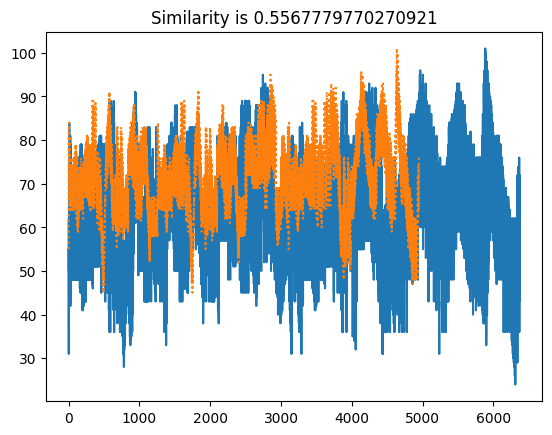

0.9605131391579999


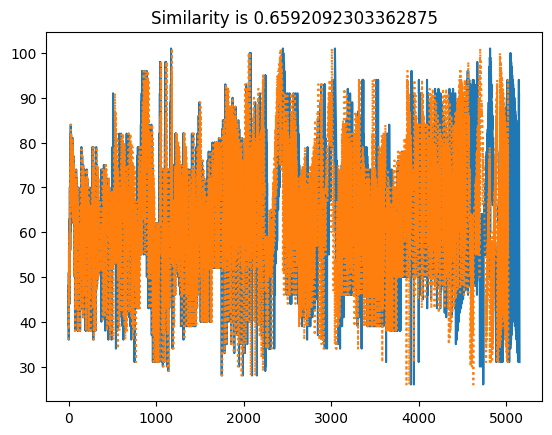

0.968156771713515


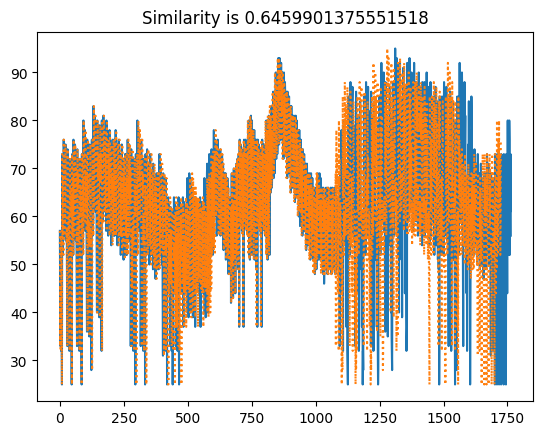

0.965477439121021


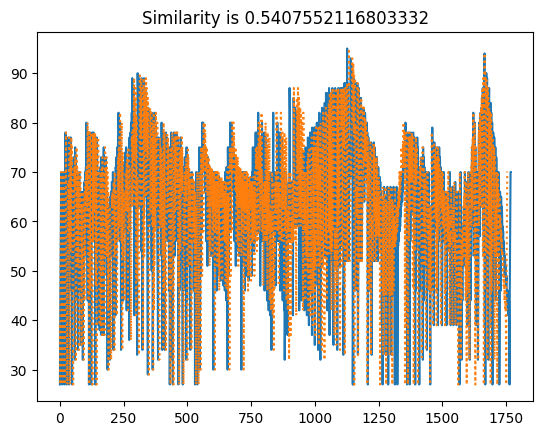

0.9866905844605937


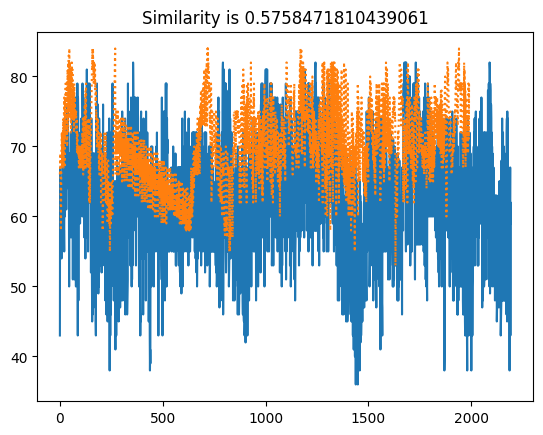

0.9809690337200083


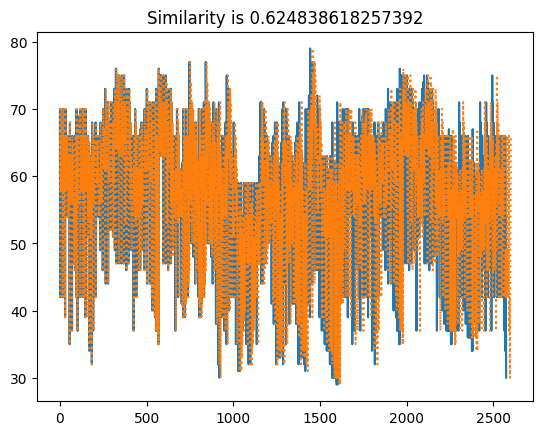

0.9731481188186226


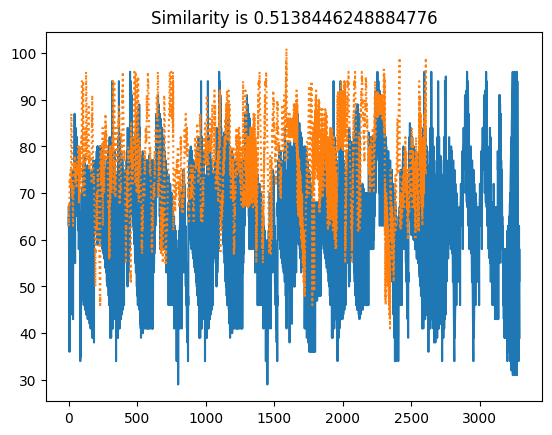

0.9765352671048435


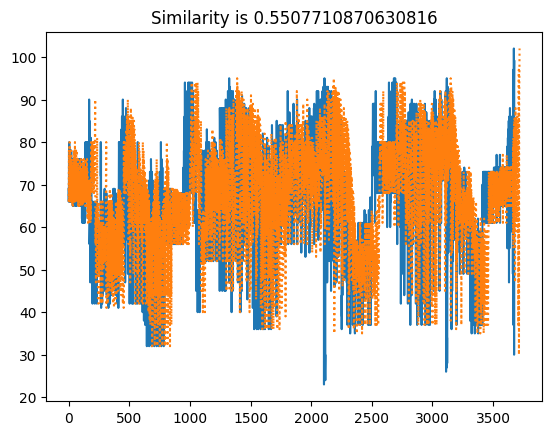

0.9636757344805208


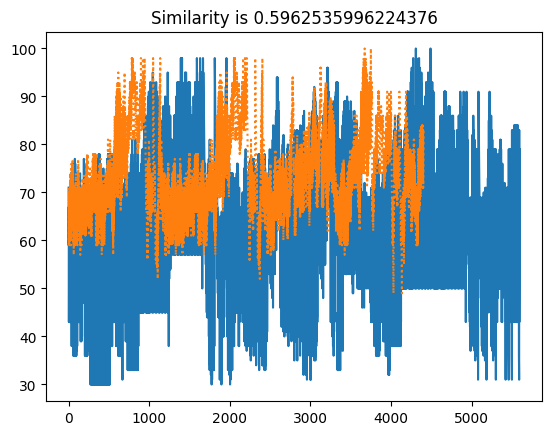

0.964085147933741


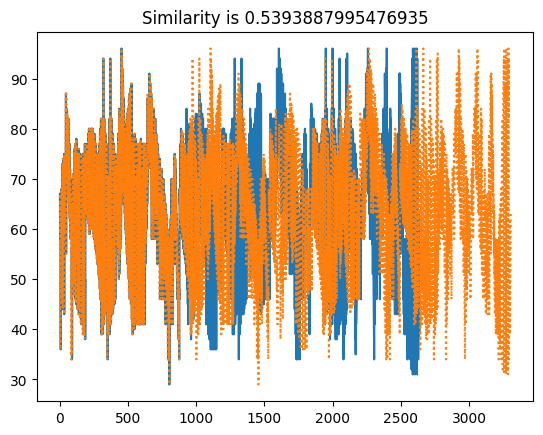

0.9713571418574276


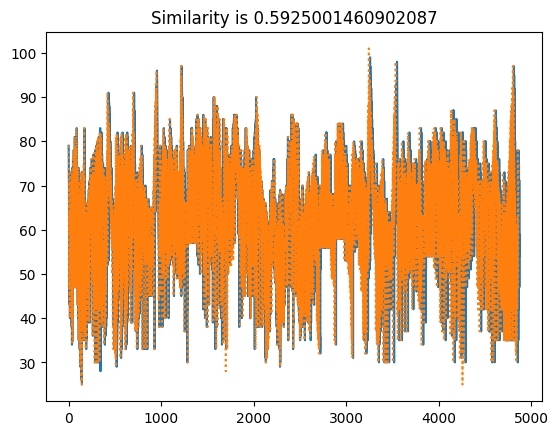

0.9649303234328271


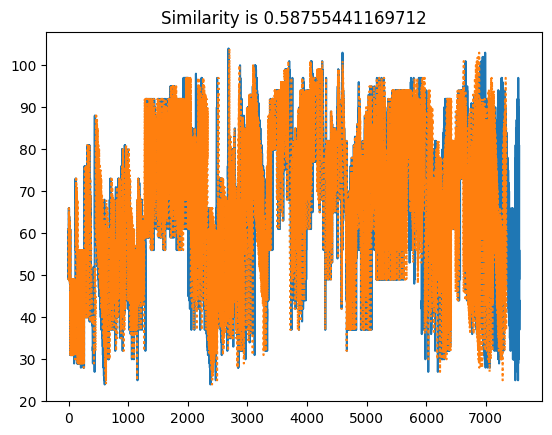

0.9692056403071623


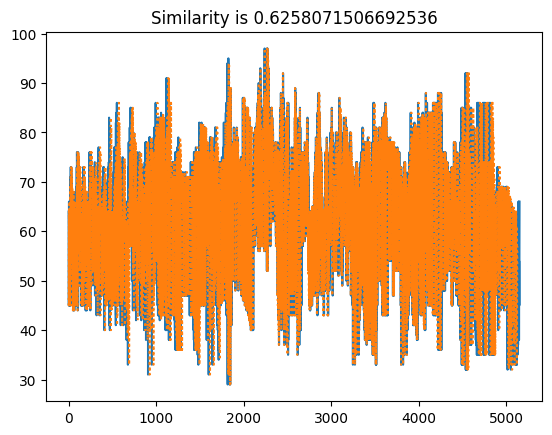

In [23]:
for match in midi_matches[0:40]:
    try:
        xn = [n.pitch for n in match[0]]
        yn = [n.pitch for n in match[1]]
        if min(len(xn), len(yn))/max(len(xn), len(yn)) < 0.75:
            continue
        print(cosine_sim(xn, yn))
        
        plt.plot(xn)
        plt.plot(yn, ls= 'dotted')
        plt.title(f"Similarity is {str(match[2])}")
        
        plt.show()

    except:
        continue
    

In [13]:
gp = pickle.load(open("data/good_pitches_flat.p", "rb"))

In [15]:
len(gp)

7308